In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from modules.dataset.tweets import Tweets
from modules.dataset.entities import Entities

In [2]:
alpha = 0.9

In [3]:
def get_adjacency_matrix(data):
    """
    Input:
        - data: pandas.DataFrame with columns names = ['index_id', 'index_tag']
    Output:
        - numpy.matrix A - Adjacency matrix
    """
    # Create networkx graph object
    graph = nx.from_pandas_edgelist(data, source='index_id', target='index_tag')
    # Check if the graph is connected
    cc = nx.number_connected_components(graph)
    if cc > 1:
        warnings.warn('The bipartite graph is not connected!')
    # Extract adjacency matrix
    A = nx.to_numpy_matrix(graph)

    return A

In [4]:
def get_google_matrix(A, e2i, cluster, alpha):
    """
    Input:
        - A       : numpy.matrix of dimension [n_nodes, n_nodes]
        - i2e     : dictionary that associates each node number to its name
        - cluster : list of strings (node names)
        - alpha   : float between 0 and 1 -- Dumping factor (which is 1 - teleport probability)
    Output:
        - numpy.matrix - Google matrix G = alpha A + (1-alpha) C
    """
    # Normalize A (stochastic on columns)
    A /= A.sum(axis=0)
    # Mask of indices in the cluster
    mask = [ e2i[e] for e in cluster ]
    # Compute google matrix
    G = alpha*A
    G[mask, :] += (1-alpha)/len(cluster)

    return G

In [5]:
def power_iteration(G, max_iter: int, tolerance=1e-3):
    """
    Input:
        - G         : squared numpy.matrix -- Google matrix
        - max_iter  : int -- maximum number of iterations
        - tolerance : float -- maximum accepted error
    Output:
        - approximate eigenvector of G (unique if G is a Google matrix)
    """
    # Choose a random vector to decrease the chance that our vector is orthogonal to the eigenvector
    b_k = np.random.rand(G.shape[1])

    for _ in range(max_iter):
        # Calculate the matrix-by-vector product Ab
        b_k1 = G @ np.reshape(b_k, (-1,1))

        # Calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # Re-normalize the vector
        b_k = b_k1 / b_k1_norm

        # If the precision increment is uniformly lower than the tolerance, break
        if np.allclose(b_k, b_k1, atol=tolerance):
            break

    return b_k

In [6]:
# Load communities data
data_path = "data/communities/"
communities = pd.read_csv(data_path+"hashtags_community_selected.csv", header=0)
communities.head()

,hashtag,community,year
0,#1,0,2017
1,#geoengineering,0,2017
2,#srm,0,2017
3,#17goals17days,1,2017
4,#development,1,2017


In [7]:
years = set(communities.year.values)
years

{2017, 2018, 2019}

In [8]:
# Load tweet_id - hashtag map
hashtags = Entities()
hashtags.from_json("data/db/hashtags.json")
hashtags.df = hashtags.df[['tweet_id','entity_text']].rename(columns={'entity_text': 'hashtag'})
hashtags.df.hashtag = hashtags.df.hashtag.apply(lambda x: x.lower())
hashtags.df.head()

,tweet_id,hashtag
0,1101574442575167489,#humans
1,1101574442575167489,#climatechange
2,1101574446341607424,#climatechange
3,1101574446341607424,#actonclimate
4,1101574446341607424,#climate


In [9]:
# drop rows with search hashtags
seed_list = ["#climatechange", "#climate", "#sdgs", "#sustainability", "#environment", "#globalwarming"]
hashtags.df = hashtags.df[~hashtags.df.hashtag.isin(seed_list)]
hashtags.df.head()

,tweet_id,hashtag
0,1101574442575167489,#humans
3,1101574446341607424,#actonclimate
5,1101574446341607424,#energy
6,1101574446341607424,#climatestrike
7,1101574446341607424,#greennewdeal


In [10]:
# Load tweet data
tweets = Tweets()
tweets.from_json("data/db/tweets.json")
tweets.df.head()

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46\n1.Hong Kong\n2.#JointAddre...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,‘Shell knew’: oil giant's 1991 film warned of ...


In [11]:
# Join with tweet_id
for year in years:
    # Select ids of the year
    curr_ids = list(tweets.df.tweet_id[tweets.df.tweet_date.dt.year == year].values)
    # Select communities of the year
    curr_communities = communities[communities.year == year]
    # Select hashtags of interest
    curr_hashtags = hashtags.df[hashtags.df.tweet_id.isin(curr_ids)]
    # Create edges
    data = curr_communities.merge(curr_hashtags, on="hashtag", how="outer")
    # Drop not-in-cluster hashtags
    data = data.loc[~data.isna().any(axis=1)]
    
    # Map entities in index
    nodes = list(data.hashtag.unique())
    nodes.extend(data.tweet_id.unique())
    e2i = dict(zip(nodes, range(len(nodes))))
    # Map index in entities
    i2e = dict(zip(range(len(nodes)), nodes))
    
    # Add indices to data
    data['index_id'] = data.tweet_id.apply(lambda x: e2i[x])
    data['index_tag'] = data.hashtag.apply(lambda x: e2i[x])
    data = data[['index_id', 'index_tag']]
    # Init metrics container for year
    clusters = curr_communities.community.unique()
    community_similarity = pd.DataFrame(columns=clusters, dtype=float)

    # Compute adjacency matrix
    A = get_adjacency_matrix(data)
    
    print("Network {:d}".format(year))
    # Loop through communities
    for cluster in clusters:
        # Compute Google matrix
        G = get_google_matrix(A, e2i, curr_communities.hashtag[curr_communities.community == cluster], alpha)
        # Compute eigenvector
        v = power_iteration(G, 100)
        # Add eigenvector to metrics container
        community_similarity[cluster] = np.array(v).squeeze()

Network 2017
Network 2018
Network 2019


In [12]:
community_similarity

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.059025,0.007191,0.004448,0.000748,0.000858,0.000907,0.000492,0.001195,0.000448,0.000596,...,0.000559,0.000115,0.000168,0.000484,0.000203,0.000160,0.000198,0.000331,0.000218,0.000027
1,0.041626,0.003292,0.002066,0.000442,0.000460,0.000555,0.000279,0.000644,0.000259,0.000325,...,0.000355,0.000095,0.000059,0.000349,0.000087,0.000060,0.000227,0.000408,0.000104,0.000010
2,0.020209,0.034173,0.012463,0.013919,0.007123,0.008409,0.009317,0.007774,0.007090,0.010074,...,0.010460,0.001775,0.002601,0.006939,0.000854,0.002992,0.002145,0.003412,0.001127,0.000289
3,0.037356,0.024211,0.015198,0.002913,0.003107,0.003599,0.001834,0.004518,0.001732,0.002218,...,0.002267,0.000505,0.000373,0.002159,0.000638,0.000389,0.001000,0.001877,0.000772,0.000058
4,0.010130,0.019128,0.004172,0.001346,0.001279,0.002573,0.000883,0.002167,0.000970,0.001287,...,0.001598,0.000212,0.000254,0.000772,0.000201,0.000280,0.000333,0.000546,0.000266,0.000039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,0.000411,0.006877,0.000347,0.000476,0.000374,0.000503,0.000406,0.000369,0.000644,0.001499,...,0.000657,0.000109,0.000103,0.000314,0.000063,0.000080,0.000136,0.000307,0.000160,0.000014
7545,0.000411,0.006877,0.000347,0.000476,0.000374,0.000503,0.000406,0.000369,0.000644,0.001499,...,0.000657,0.000109,0.000103,0.000314,0.000063,0.000080,0.000136,0.000307,0.000160,0.000014
7546,0.000234,0.000394,0.000370,0.000249,0.000366,0.000287,0.001622,0.000292,0.007599,0.000252,...,0.001367,0.000107,0.001538,0.000307,0.000012,0.000065,0.000141,0.000329,0.000034,0.000011
7547,0.000714,0.000712,0.000331,0.000613,0.001598,0.000860,0.000467,0.016617,0.000406,0.000283,...,0.000634,0.000155,0.000368,0.001327,0.000062,0.000384,0.000291,0.000763,0.000100,0.000053


In [13]:
import matplotlib.pyplot as plt

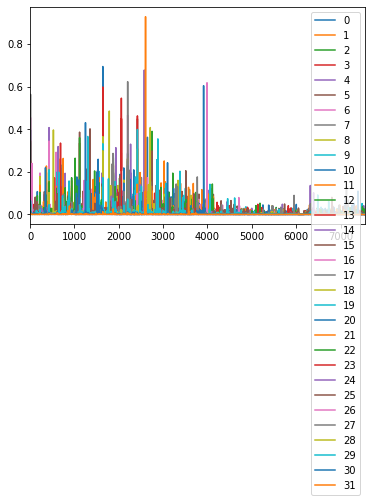

In [47]:
community_similarity.plot()
plt.show()

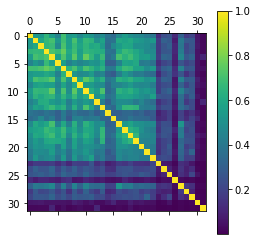

In [45]:
plt.matshow(community_similarity.corr())
plt.colorbar()
plt.show()